# Анализ поведения пользователей мобильного приложения

In [1]:
# Импортируем необходимые для работы библиотеки
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import scipy.stats as st 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
file_path = 'r/datasets/logs_exp.csv'
df = pd.read_csv(file_path, sep='\t')
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


***
**Пропусков в данных не обнаружено. Переименуем названия столбцов для удобства работы. Создадим отдельную колонку с датой и временем в формате datetime UTC, а также отдельные колонки с датой и временем**
***

# Подготовка и предварительное ознакомление с данными

In [4]:
df.columns=['event_name', 'device_id', 'unix_time', 'exp_id'] # переименование столбцов
df['event_time'] = pd.to_datetime(df.unix_time, unit='s') # столбец с датой и временес временем в формате UTC
df['date'] = pd.to_datetime(df.event_time).dt.date # столбец с датой
df['time'] = pd.to_datetime(df.event_time).dt.time # столбец со временем

In [5]:
print('Полных дубликатов в датафрейме:', df.duplicated().sum())
print(f'Доля дубликатов:, {df.duplicated().sum() / len(df) * 100:.2f}%')

Полных дубликатов в датафрейме: 413
Доля дубликатов:, 0.17%


In [6]:
df.drop_duplicates(inplace=True) # избавимся от дубликатов

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   device_id   243713 non-null  int64         
 2   unix_time   243713 non-null  int64         
 3   exp_id      243713 non-null  int64         
 4   event_time  243713 non-null  datetime64[ns]
 5   date        243713 non-null  object        
 6   time        243713 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 14.9+ MB


In [8]:
print('Событий в логе, всего:', len(df))

Событий в логе, всего: 243713


In [9]:
print('Уникальные названия событий:')
for i in df.event_name.unique():
    print('-', i)
    

Уникальные названия событий:
- MainScreenAppear
- PaymentScreenSuccessful
- CartScreenAppear
- OffersScreenAppear
- Tutorial


In [10]:
print('Количество уникальных пользователей:', df.device_id.nunique())

Количество уникальных пользователей: 7551


In [11]:
print(f'На одного пользователя в среднем приходится {round(len(df) / len(df.device_id.unique()))} события')

На одного пользователя в среднем приходится 32 события


In [26]:
df.groupby('device_id')['event_name'].count().describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_name, dtype: float64

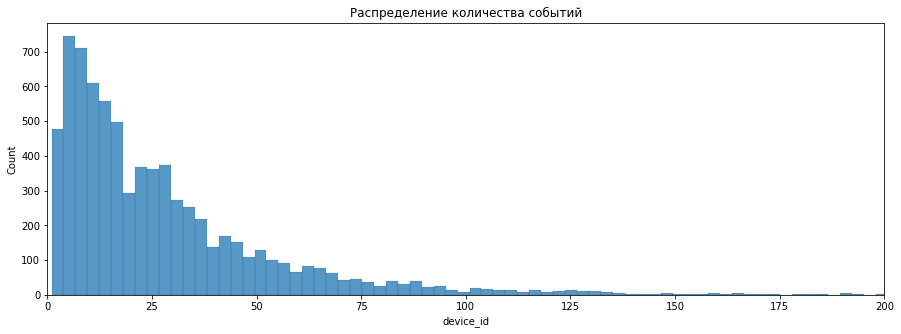

In [22]:
plt.figure(figsize=(15,5))
sns.histplot(df.device_id.value_counts())
plt.xlim(0, 200)
plt.title('Распределение количества событий');

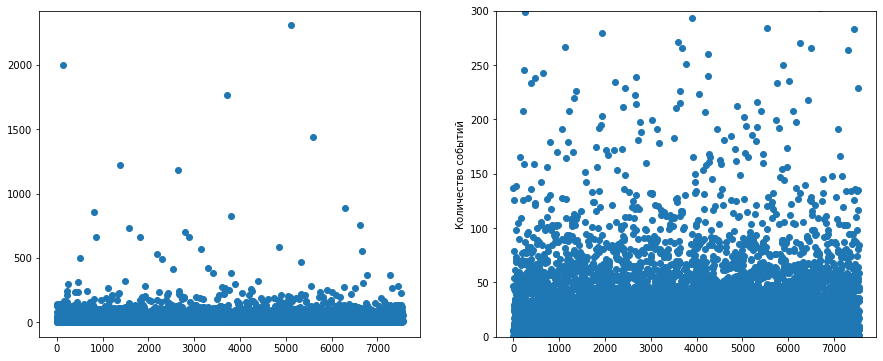

In [14]:
plt.figure(figsize=(15,6))
plt.title('Количество событий для каждого пользователя')

plt.subplot(1,2,1)
plt.scatter(x=range(0,7551), y=df.groupby('device_id')['event_name'].count())

plt.subplot(1,2,2)
plt.scatter(x=range(0,7551), y=df.groupby('device_id')['event_name'].count())
plt.ylim(0, 300)
plt.ylabel('Количество событий');

In [27]:
events_per_day = df.groupby('date', as_index=False).agg({'event_name':'count'})
fig = px.bar(events_per_day, x='date', y='event_name',
            labels={'date':'Дата', 'event_name':'Количество событий'},
            title='Количество событий по датам')
fig.update_layout(title_x=0.5)
fig.show()

***
**В датасете представлены данные в промежутке с 25 июля до 7 августа 2019 года, однако вплоть до 31 июля включительно данных несравнимо меньше. Далее будем исследовать период с 1 по 7 августа включительно, в каждый из этих дней количество событий превышало 30 тысяч.**
***

In [28]:
df_aug = df[df['event_time'] >= '2019-08-01'] # новый датафрейм с событиями в августе
diff_events = len(df) - len(df_aug)
diff_perc = round(diff_events / len(df) * 100)
diff_users = len(df.device_id.unique()) - len(df_aug.device_id.unique())
diff_users_perc = round(
    (len(df.device_id.unique()) - len(df_aug.device_id.unique())) \
    / len(df.device_id.unique()) * 100, 2)
print(f'При отсечении данных за июль мы теряем данные о {diff_events} событиях и {diff_users} пользователях \
\nчто составляет {diff_perc} % событий и {diff_users_perc} % пользователей')

При отсечении данных за июль мы теряем данные о 2826 событиях и 17 пользователях 
что составляет 1 % событий и 0.23 % пользователей


In [29]:
print('Номера экспериментальных групп в новом датафрейме:', df_aug.exp_id.unique())

Номера экспериментальных групп в новом датафрейме: [246 247 248]


#  Воронка событий

## Какие события есть в логах, как часто они встречаются?

In [30]:
fig = px.bar(df_aug.event_name.value_counts(),
            labels={'value':'Частота события', 'index':'Название события'},
            height=300)
fig.update_layout(showlegend=False)
fig.show()

event_freq_per_group = df_aug.groupby(['event_name', 'exp_id'], as_index=False)['device_id'].count()
fig = px.histogram(event_freq_per_group.sort_values(by='device_id', ascending=False),
                   x='event_name', y='device_id', color='exp_id', barmode='group',
                  labels={'device_id':'Количество событий',
                         'event_name':'События',
                         'exp_id':'Группа'},
                  height=300)
fig.show()

***
**В логах 5 уникальных событий:**
- показ главной страницы - **MainScreenAppear**
- показ страницы с предложениями - **Offers Screen Appear**
- показ корзины с товарами - **Cart Screen Appear**
- страница с уведомлением об успешном платеже - **Payment Screen Successful**
- обучению использованию приложения - **Tutorial**

**Количество событий распределено между группами довольно равномерно**
***

## Cколько пользователей совершали каждое из событий? Какова доли пользователей, которые хоть раз совершали событие.

In [38]:
users_per_event = df_aug.groupby('event_name', as_index=False) \
                    .agg({'device_id':'nunique'}).sort_values(by='device_id', ascending=False)

unique_users_per_group_event = df_aug.groupby(['event_name', 'exp_id'], as_index=False)['device_id'].nunique()

fig = px.sunburst(unique_users_per_group_event, 
                  values='device_id', 
                  path=['event_name', 'exp_id'],
                 title='Доли экспериментальных групп для каждого события',
                 labels={'labels':'Группа',
                        'device_id':'Количество событий'},
                 height=400)
fig.update_layout(title_x=0.5)
fig.show()


In [39]:
print('Доли пользователей, хотя бы раз совершавших события, следующие:')
users_per_event['share, %'] = round(users_per_event.device_id / df.device_id.nunique() * 100,1)
users_per_event

Доли пользователей, хотя бы раз совершавших события, следующие:


,event_name,device_id,"share, %"
1,MainScreenAppear,7419,98.3
2,OffersScreenAppear,4593,60.8
0,CartScreenAppear,3734,49.5
3,PaymentScreenSuccessful,3539,46.9
4,Tutorial,840,11.1


## Предполагаемый порядок событий

***
**Tutorial явно выбивается из ряда - его проходит очень малая доля пользователей, большая часть просто пропускает**
***
**Можно предположить, что последовательная цепочка выглядит следующим образом:**

*Main Screen Appear → Offers Screen Appear → Cart Screen Appear → Payment Screen Successful*
***
**Доля пользователей на каждом из этапов снижается, часть из них отпадает**
***

## По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки

In [40]:
user_groups_per_event = df_aug.query('event_name != "Tutorial"') \
                        .groupby(['event_name', 'exp_id'], as_index=False) \
                        .agg({'device_id':'nunique'}) \
                        .sort_values(by='device_id', ascending=False)

no_tutorial = df_aug.query('event_name != "Tutorial"') \
                .groupby('event_name') \
                .device_id.nunique().to_frame().reset_index() \
                .sort_values(by='device_id', ascending=False)

In [41]:
fig = make_subplots(rows=2, cols=1, shared_yaxes=True)

trace_1 = go.Funnel(x=no_tutorial.device_id, y=no_tutorial.event_name,
                           textinfo='value + percent initial + percent previous',
                   showlegend=False)
trace_2 = go.Funnel(name='246', 
                        y=user_groups_per_event.query('exp_id == 246').event_name,
                        x =user_groups_per_event.query('exp_id == 246').device_id,
                        textinfo='value+percent initial+percent previous')
                        
trace_3 = go.Funnel(name='247', 
                        y=user_groups_per_event.query('exp_id == 247').event_name,
                        x =user_groups_per_event.query('exp_id == 247').device_id,
                        textinfo='value+percent initial+percent previous')
trace_4 = go.Funnel(name='248', 
                        y=user_groups_per_event.query('exp_id == 248').event_name,
                        x =user_groups_per_event.query('exp_id == 248').device_id,
                        textinfo='value+percent initial+percent previous')

fig.add_trace(trace_1, col=1, row=2)
fig.add_trace(trace_2, col=1, row=1)
fig.add_trace(trace_3, col=1, row=1)
fig.add_trace(trace_4, col=1, row=1)
fig.update_layout(height=1000, width=900)

**Судя по выстроенной воронке, 48% пользователей доходит от главного экрана до покупки. Наибольшая часть отваливается между 1 и 2 шагами**

# Результаты эксперимента

## Сколько пользователей в каждой экспериментальной группе?

***
**Колонка exp_id — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.**
***

In [42]:
users_per_group = pd.DataFrame(df.groupby('exp_id', as_index=False).device_id.nunique())
users_per_group.columns = ['Группа', "Количество пользователей"]
users_per_group

,Группа,Количество пользователей
0,246,2489
1,247,2520
2,248,2542


## Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Есть ли статистически значимый различия между выборками 246 и 247?

In [43]:
group_a1 = df_aug.query('exp_id == 246')
group_a2 = df_aug.query('exp_id == 247')
group_b = df_aug.query('exp_id == 248')

In [44]:
print(f'Общих пользователей в группах A1 & A2 - {len(np.intersect1d(group_a1.device_id, group_a2.device_id))}')
print(f'Общих пользователей в группах A1 & B - {len(np.intersect1d(group_a1.device_id, group_b.device_id))}')
print(f'Общих пользователей в группах A2 & B - {len(np.intersect1d(group_a2.device_id, group_b.device_id))}')

Общих пользователей в группах A1 & A2 - 0
Общих пользователей в группах A1 & B - 0
Общих пользователей в группах A2 & B - 0


In [45]:
users_by_group = df_aug.groupby('exp_id').device_id.nunique()
users_by_group.index = ['a1', 'a2', 'b']
users_by_group['a1 + a2'] = 2484 + 2513

In [46]:
table = df_aug.query('event_name != "Tutorial"') \
        .pivot_table(index='event_name', columns='exp_id', values='device_id', aggfunc='nunique', ) \
        .reset_index()
# table['a+b'] = table['a1'] + table['a2']
table.columns = ['event_name', 'a1', 'a2', 'b']
table['a1 + a2'] = table['a1'] + table['a2']
table

,event_name,a1,a2,b,a1 + a2
0,CartScreenAppear,1266,1238,1230,2504
1,MainScreenAppear,2450,2476,2493,4926
2,OffersScreenAppear,1542,1520,1531,3062
3,PaymentScreenSuccessful,1200,1158,1181,2358


In [47]:
# Функция для оценки результатов А\А\Б - теста
def aabtest(group1, group2, alpha):
    for i in table.index:
        p1 = table[group1][i] / users_by_group[group1]
        p2 = table[group2][i] / users_by_group[group2]
        p_combined = (table[group1][i] + table[group2][i]) / (users_by_group[group1] +  users_by_group[group2])
        diff = p1 - p2
        z_value = diff / np.sqrt(
            p_combined * (1-p_combined) * (1/users_by_group[group1] + 1/users_by_group[group2]))
        distr = st.norm(0,1)
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        if p_value < alpha:
            print(f'{table.event_name[i]}: p-value = {p_value:.2f}, обнаружены статистически значимые отличия')
        else:
            print(f'{table.event_name[i]}: p-value = {p_value:.2f}, статистически значимых отличий нет')

## Посчитаем число и долю пользователей, совершивших самое популярное событие в каждой из контрольных групп.  Проверим, будет ли отличие между группами статистически достоверным. Проделаем то же самое для всех других событий.

***
**Гипотезы:**
- H0 - статистически значимых различий между контрольными и экспериментальной группами нет
- H1 - изменение шрифта приводит к появлению статистически значимых различий
***

In [48]:
print('Сравнение групп A1 и А2 с уровнем значимости 0,01:')
print()
aabtest('a1', 'a2', 0.01)

Сравнение групп A1 и А2 с уровнем значимости 0,01:

CartScreenAppear: p-value = 0.23, статистически значимых отличий нет
MainScreenAppear: p-value = 0.76, статистически значимых отличий нет
OffersScreenAppear: p-value = 0.25, статистически значимых отличий нет
PaymentScreenSuccessful: p-value = 0.11, статистически значимых отличий нет


**Для сравнения А\А был выбран уровень значимости 0,01 для большей точности, т.к группам показывали страницы с одинаковым шрифтом, и различий между ними быть не должно**
***
**По результатам А\А теста с уровнем значимости 0.01 статистически значимых различий нет. Группы сформированы корректно, тест можно продолжать**

## Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию и с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

In [49]:
print('Сравнение групп A1 и B с уровнем значимости 0,05:')
print()
aabtest('a1', 'b', 0.05)

Сравнение групп A1 и B с уровнем значимости 0,05:

CartScreenAppear: p-value = 0.08, статистически значимых отличий нет
MainScreenAppear: p-value = 0.29, статистически значимых отличий нет
OffersScreenAppear: p-value = 0.21, статистически значимых отличий нет
PaymentScreenSuccessful: p-value = 0.21, статистически значимых отличий нет


**Между группами А1 и В статистически значимых отличий не найдено ни на одном из этапов**

In [50]:
print('Сравнение групп A2 и B с уровнем значимости 0,05:')
print()
aabtest('a2', 'b', 0.05)

Сравнение групп A2 и B с уровнем значимости 0,05:

CartScreenAppear: p-value = 0.58, статистически значимых отличий нет
MainScreenAppear: p-value = 0.46, статистически значимых отличий нет
OffersScreenAppear: p-value = 0.92, статистически значимых отличий нет
PaymentScreenSuccessful: p-value = 0.74, статистически значимых отличий нет


**Между группами А2 и В статистически значимых отличий не найдено ни на одном из этапов**

In [51]:
print('Сравнение групп A1+А2 и B с уровнем значимости 0,05:')
print()
aabtest('a1 + a2', 'b', 0.05)

Сравнение групп A1+А2 и B с уровнем значимости 0,05:

CartScreenAppear: p-value = 0.18, статистически значимых отличий нет
MainScreenAppear: p-value = 0.29, статистически значимых отличий нет
OffersScreenAppear: p-value = 0.43, статистически значимых отличий нет
PaymentScreenSuccessful: p-value = 0.60, статистически значимых отличий нет


**Между совмещенной контрольной группой и группой В статистически значимых отличий не найдено ни на одном из этапов**

***
**Для А\В тестов был выбран уровень значимости 0.05. Впрочем, и при уровне значимости в 0.01 результаты были бы те же самые.**
***
**Таким образом, нулевую гипотезу об отсутствии влияния изменения шрифтов не получилось опровергнуть**
***

# Общий вывод
***
- мы загрузили и обработали данные, привели к нужным типам, избавились от дубликатов.
- в датасете есть достаточный объем данных за первую неделю августа - мы анализировали именно этот период
- на одного пользователя в среднем приходится 32 события. Среди аномально активных пользователей относительная различных событий не отличается от нормальных.

**Пользователи разбиты на 3 группы - 2 контрольные и 1 экспериментальная. Количество пользователей в группах отличается незначительно**

**Доли пользователей, хотя бы раз совершавших события, одинаковые для всех групп:**

- Main Screen Appear - 36.9%
- Offers Screen Appear - 22.8%
- Cart Screen Appear - 18,6 %
- Payment Screen Successful - 17.6%
- Tutorial - 4.1%

**Предполагаемая цепочка событий:**

Main Screen Appear → Offers Screen Appear → Cart Screen Appear → Payment Screen Successful

Судя по выстроенной воронке, 48% пользователей доходит от главного экрана до покупки. Наибольшая часть отваливается между 1 и 2 шагами - 38 процентов

**Мы проверили гипотезу о влиянии изменения шрифтов на пользовательское поведение**

- H0 - статистически значимых различий между контрольными и экспериментальной группами нет
- H1 - изменение шрифта приводит к появлению статистически значимых различий

Между контрольными группами при А\А-тесте не было выявлено статистически значимых различий при p-value 0.01

При кросс-сравнении обеих контрольных групп и совмещенной контрольной группы с экспериментальной не было выявлено статистически значимых различий ни на одном из этапов функционирования приложения, p-value 0.05

***У нас нет оснований отклонять нулевую гипотезу.***